In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [2]:
from scipy import stats as spstats
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import numba
from numba import jit

In [4]:
import torch
import sbi 

import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn


In [5]:
import pystan

In [6]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
import warnings
warnings.simplefilter("ignore")

In [9]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.19.0
Running on torch: v1.8.0
Running on sbi: v0.15.1


In [10]:
cwd = os.getcwd()
cwd

'/data/MPR_NMM_SBI_HMC'

In [11]:
Res_dir='Res_syntheticData' 

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [12]:
def Montbrio_SDEmodel(params, constants, I_input, sigma, dt, ts):
   
    delta, alpha, beta  = params[0], params[1], params[2]
    
    eta=alpha*delta
    J=beta*np.sqrt(delta)

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init
        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [13]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

In [14]:
delta=0.7
eta=-4.6
J=14.5

In [15]:
alpha=eta/delta
beta=J/np.sqrt(delta)

In [16]:
alpha, beta

(-6.571428571428571, 17.330814835348708)

In [17]:
params=[delta, alpha, beta]

In [18]:
t_init = 0.0
t_final = 100.0

dt = 0.01
ts = np.arange(t_init,t_final,dt)
ts.shape

(10000,)

In [19]:
sigma=0.1

In [20]:
nIsteps = int((t_final - t_init)/dt)
nIsteps

10000

In [21]:
I0=3.
t_on=30.
t_off=60.

In [22]:
I_input=[]
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]

In [23]:
I_input =np.asarray(I_input)
I_input.shape

(10000,)

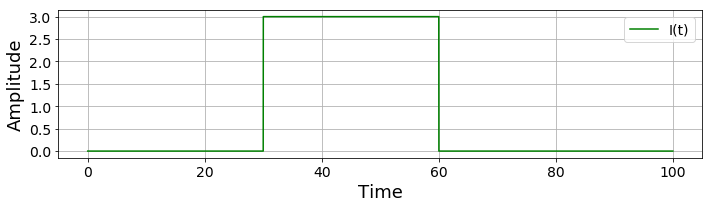

In [24]:
plt.figure(figsize=(10, 3))
plt.plot(ts, I_input,color='g' , label='I(t)')
plt.xlabel('Time', fontsize=18); 
plt.ylabel('Amplitude', fontsize=18); 
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

In [25]:
v0 = -3.
r0 = 0.5

In [26]:
constants=[v0, r0]

In [27]:
start_time = time.time()

rv = Montbrio_SDEmodel(params, constants, I_input, sigma, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.0724489688873291 seconds ---


In [28]:
start_time = time.time()

rv = Montbrio_SDEmodel_numba(params, constants, I_input, sigma, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:numba.core.transforms:finding looplift candidates


------------------------------------------------------------
--- 1.2734355926513672 seconds ---


In [29]:
start_time = time.time()

rv = Montbrio_SDEmodel_numba(params, constants, I_input, sigma, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.0016632080078125 seconds ---


In [30]:
v=rv[0:nIsteps]
r=rv[nIsteps:2*nIsteps]

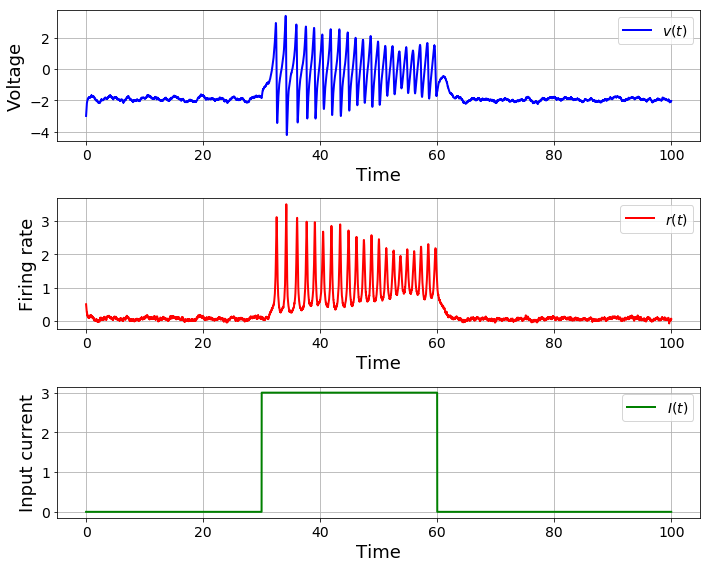

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Voltage', fontsize=18); 
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(312)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Firing rate', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(313)
plt.plot(ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Input current', fontsize=18); 
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_Istep.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_Istep.eps"), doi=800)

plt.show()

## 1. Simulator


In [32]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.01
    ts = np.arange(t_init,t_final,dt)
    sigma=0.1
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    rv = Montbrio_SDEmodel_numba(params, constants, I_input, sigma, dt, ts)

    return rv.reshape(-1)  

### Data

In [33]:
params_label=np.array(['delta', 'alpha', 'beta'])
params_label=np.array(['$\Delta$', '$alpha$', '$beta$'])

In [34]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

In [35]:
alpha_true=eta_true/delta_true

beta_true=J_true/np.sqrt(delta_true)

In [36]:
true_params = np.array([delta_true, alpha_true, beta_true])

In [37]:
y_obs=Montbrio_SDEmodel_Wrapper(params=true_params)
y_obs.shape

INFO:numba.core.transforms:finding looplift candidates


(20000,)

In [38]:
y_obs=np.load(os.path.join(cwd+'/'+str(Res_dir), 'y_obs1.npy' ))

In [39]:
vs=y_obs[0:int(y_obs.shape[0]/2)]
rs=y_obs[int(y_obs.shape[0]/2): int(y_obs.shape[0])]

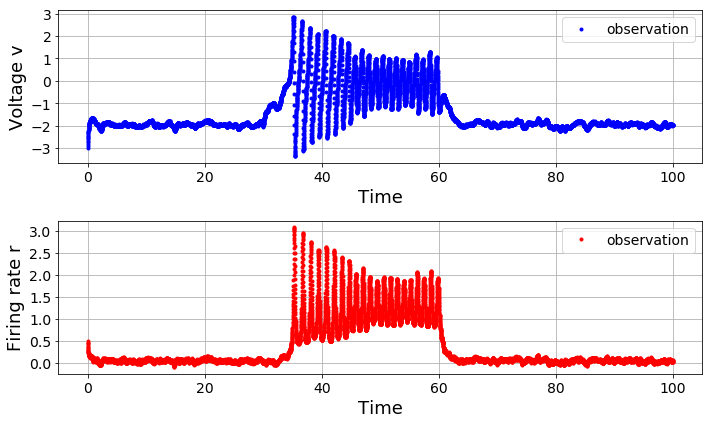

In [40]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, vs, '.', color='blue', label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, rs, '.', color='red',label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs1.eps"), doi=800)

plt.show()

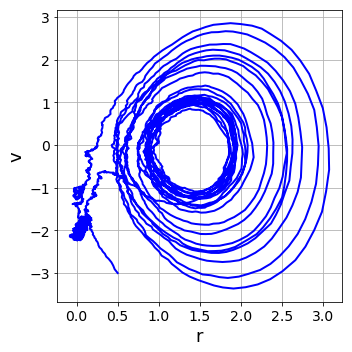

In [41]:
plt.figure(figsize=(5, 5))
plt.plot(rs, vs, 'b', linewidth=2)
plt.xlabel('r', fontsize=18); plt.ylabel('v', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs1_phaseplane.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs1_phaseplane.eps"), doi=800)
plt.show()

In [42]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'y_obs1.npy' ) , y_obs)

In [43]:
data_iput_filename=str('data_input_mpr_sd1')

In [44]:
data_iput_dict= {
    'nt': ts.shape[0], 'ts': ts, 'dt': dt, 't0': t_init, 't_final': t_final,  'I0': I0, 't_on': t_on, 't_off': t_off, 'I_input': I_input, 'sigma': sigma, 
    'vs':vs, 'rs':rs, 'r_init': r0, 'v_init': v0, 
    'delta_true':delta_true, 'eta_true':eta_true, 'J_true':J_true, 'alpha_true':alpha_true, 'beta_true':beta_true, 
    'rlim': np.r_[0.0, 8.0],'vlim': np.r_[-8.0, 8.0],
}

In [45]:
nd=[]
npz = {'nd': nd}
npz.update(data_iput_dict)
np.savez(cwd+'/'+str(Res_dir)+'/data_input_files/'+ str(data_iput_filename) +'.R.npz', **npz)
np.savez(cwd+'/'+str(Res_dir)+'/data_input_files/'+ str(data_iput_filename) +'.npz', **npz)
pystan.stan_rdump(data_iput_dict, cwd+'/'+str(Res_dir)+'/data_input_files/' + str(data_iput_filename)+ '.R')

### Another data set

In [46]:
params_label=np.array(['delta', 'alpha', 'beta'])
params_label=np.array(['$\Delta$', '$alpha$', '$beta$'])

In [47]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

In [48]:
alpha_true=eta_true/delta_true

beta_true=J_true/np.sqrt(delta_true)

In [49]:
true_params = np.array([delta_true, alpha_true, beta_true])

In [50]:
y_obs=Montbrio_SDEmodel_Wrapper(params=true_params)

In [51]:
y_obs=np.load(os.path.join(cwd+'/'+str(Res_dir), 'y_obs2.npy' ))

In [52]:
vs=y_obs[0:int(y_obs.shape[0]/2)]
rs=y_obs[int(y_obs.shape[0]/2): int(y_obs.shape[0])]

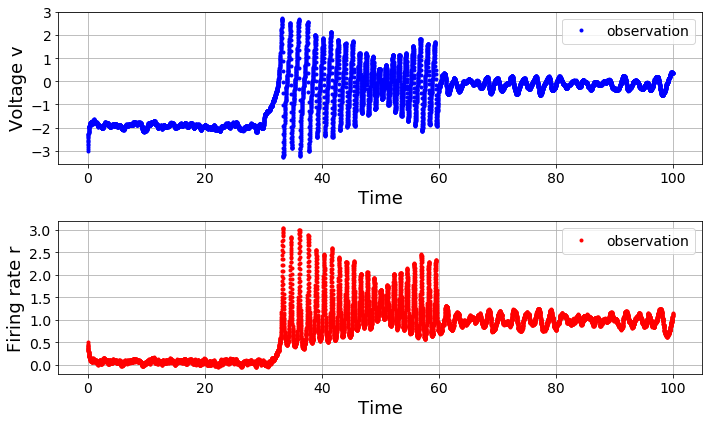

In [53]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, vs, '.', color='blue', label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, rs, '.', color='red',label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs2.eps"), doi=800)

plt.show()

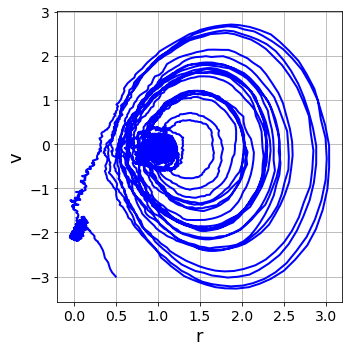

In [54]:
plt.figure(figsize=(5, 5))
plt.plot(rs, vs, 'b', linewidth=2)
plt.xlabel('r', fontsize=18); plt.ylabel('v', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs2_phaseplane.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Monbtbrio_NMM_sde_obs2_phaseplane.eps"), doi=800)
plt.show()

In [55]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'y_obs2.npy' ) , y_obs)

In [56]:
data_iput_filename=str('data_input_mpr_sd2')

In [57]:
data_iput_dict= {
    'nt': ts.shape[0], 'ts': ts, 'dt': dt, 't0': t_init, 't_final': t_final,  'I0': I0, 't_on': t_on, 't_off': t_off, 'I_input': I_input, 'sigma': sigma, 
    'vs': vs, 'rs': rs, 'r_init': r0, 'v_init': v0, 
    'delta_true':delta_true, 'eta_true':eta_true, 'J_true':J_true, 'alpha_true':alpha_true, 'beta_true':beta_true, 
    'rlim': np.r_[0.0, 8.0],'vlim': np.r_[-8.0, 8.0],
}

In [58]:
nd=[]
npz = {'nd': nd}
npz.update(data_iput_dict)
np.savez(cwd+'/'+str(Res_dir)+'/data_input_files/'+ str(data_iput_filename) +'.R.npz', **npz)
np.savez(cwd+'/'+str(Res_dir)+'/data_input_files/'+ str(data_iput_filename) +'.npz', **npz)
pystan.stan_rdump(data_iput_dict, cwd+'/'+str(Res_dir)+'/data_input_files/' + str(data_iput_filename)+ '.R')